# Hand digit classifier 
---
## Incremental network quantization

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from skimage import io

### Importing MNIST dataset

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

train_data = torchvision.datasets.MNIST(root='../', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root="../", train=False, download=True, transform=transform)

train_set = [train_data[i] for i in range(50000)]
validation_set = [train_data[i] for i in range(50000, 60000)]

### Setting up data loaders

In [3]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

### Definig a VGG-7 inspired architecture model
---
Featuring 4 convolutional and 3 fully connected layers

In [4]:
class VGG7(nn.Module):
    def __init__(self):
        super(VGG7, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding="same", stride=1, bias=False)
        self.conv2 = nn.Conv2d(64, 64, 3, padding="same", stride=1, bias=False)
        self.conv3 = nn.Conv2d(64, 128, 3, padding="same", stride=1, bias=False)
        self.conv4 = nn.Conv2d(128, 128, 3, padding="same", stride=1, bias=False)
        
        self.fc1 = nn.Linear(7*7*128, 512, bias=False)
        self.fc2 = nn.Linear(512, 256, bias=False)
        self.fc3 = nn.Linear(256, 10, bias=False)

    def forward(self, x): 
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, stride=2)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, stride=2)  

        x = x.view(-1, 7*7*128)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)  

        x = F.log_softmax(x, dim=1)  

        return x

### Utility functions

In [5]:
def evaluateModel(net, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    net.eval()

    correct = 0
    loss = 0
    confusion_matrix = np.zeros((10, 10))

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = net(data)
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            loss += F.nll_loss(output, target, reduction="sum").item()
            confusion_matrix[pred.view(-1), target] += 1

    print("[OK] Model evaluation complete [OK]")
    print("Average loss: {:.5f}".format(loss/len(test_loader.dataset)))
    print("Accuracy: {:.2f}%".format(100.*(correct/len(test_loader.dataset))))

    fig, ax = plt.subplots()
    ax.imshow(confusion_matrix/len(train_loader.dataset))
    ax.set_xticks(np.arange(10))
    ax.set_yticks(np.arange(10))
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predictions")
    ax.set_title("Confusion matrix")
    fig.set_size_inches(4, 4)

### Shift Quantization operations

In [6]:
def getBounderyExponents(W, b):
    s = torch.max(torch.abs(W)).item()
    n1 = np.floor(np.log2(4*(s/3)))
    n2 = n1 + 1 - (2**(b - 1))/2
    return n1, n2


def getQuantizationMask(W, percentage, T):
    w = W.view(-1)
    t = T.view(-1)
    idx = t == 1

    numberOfWeights = w.size(dim=0)
    numberOfQWeights = int(percentage*numberOfWeights - t[idx].size(dim=0))

    t_aux = torch.Tensor(np.ones_like(T)).view(-1)
    w = w*(t_aux - t)
    w = torch.abs(w)
    sorted_w, indices_w = w.sort()
    t[indices_w[-numberOfQWeights:]] = 1
    
    return t.view(T.size())


def getFcQuantizationMask(In, percentage, T):
    Ax = torch.Tensor(np.zeros_like(In.data))
    eps = 1e-45

    for i in range(len(In)):
      Ax[i] = torch.where(T[i] == 0, In[i], 0)
      if T[i] == 0 and In[i] == 0:
        Ax[i] = eps

    w_abs=torch.abs(Ax)
    values_sort,indexes_sort=torch.sort(w_abs,descending=True)
    count = torch.sum(T == 1)
    k=np.floor(len(In)*percentage)-count
    k=int(k)

    if k < 0:
      k = 0

    sorted_indexes=indexes_sort[:int(k)]

    for i in range(len(sorted_indexes)):
        T[sorted_indexes[i]] = 1


def quantizeWeights(W, T, n1, n2):
    T_aux = torch.Tensor(np.ones_like(T))
    eps = 1e-6
    W1 = W*(T_aux - T)
    idx = W == 0
    W.data[idx] = eps

    closestExp = torch.floor(torch.log2(torch.abs(W*4/3)))
    Q = W1 + torch.sign(W)*(2**closestExp)*T

    idx = closestExp*T < n2
    Q[idx] = 0
    idx = ((closestExp > n1)*T).bool()
    Q[idx] = 2**n1

    return closestExp, Q


def quantize_conv_layer(W, T, percentage, number_of_bits):
    n = T.size(dim=0)
    m = T.size(dim=1)

    n1, n2 = getBounderyExponents(W, number_of_bits)

    for i in range(n):
        for j in range(m):
            T[i, j, :, :] = getQuantizationMask(W[i, j, :, :], percentage, T[i, j, :, :])
            _, W.data[i, j, :, :] = quantizeWeights(W[i, j, :, :], T[i, j, :, :], n1, n2)


def quantize_fc_layer(W, T, percentage, number_of_bits):
    n1, n2 = getBounderyExponents(W, number_of_bits)
    n = W.size(dim=1)

    for i in range(n):
        getFcQuantizationMask(W[:, i], percentage, T[:, i])
        _, W.data[:, i] = quantizeWeights(W[:, i], T[:, i], n1, n2)

### Device initialization for training

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
net = torch.load("../Baseline/baseline.pth")
net.to(device)

optimizer = optim.SGD(net.parameters(), lr = 1e-2, weight_decay=0)

quantization_percentages = [0.5, 0.75, 0.875]
quantization_precision = 7

epochs = 4
logs_interval = 100
iteration = 0
train_loss = []

Tconv1 = torch.zeros_like(net.conv1.weight)
Tconv2 = torch.zeros_like(net.conv2.weight)
Tconv3 = torch.zeros_like(net.conv3.weight)
Tconv4 = torch.zeros_like(net.conv4.weight)
Tfc1 = torch.zeros_like(net.fc1.weight)
Tfc2 = torch.zeros_like(net.fc2.weight)
Tfc3 = torch.zeros_like(net.fc3.weight)

net.train()

for q_stage, percentage in enumerate(quantization_percentages):
    # quantize layers
    quantize_conv_layer(net.conv1.weight, Tconv1, percentage, quantization_precision)
    quantize_conv_layer(net.conv2.weight, Tconv2, percentage, quantization_precision)
    quantize_conv_layer(net.conv3.weight, Tconv3, percentage, quantization_precision)
    quantize_conv_layer(net.conv4.weight, Tconv4, percentage, quantization_precision)
    quantize_fc_layer(net.fc1.weight, Tfc1, percentage, quantization_precision)
    quantize_fc_layer(net.fc2.weight, Tfc2, percentage, quantization_precision)
    quantize_fc_layer(net.fc3.weight, Tfc3, percentage, quantization_precision)
    
    # correct remaining weights by training
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = net(data)
            loss = F.nll_loss(output, target)
            loss.backward()

            # setam gradienti la 0
            net.conv1.weight.grad = net.conv1.weight.grad*(torch.ones_like(Tconv1) - Tconv1)
            net.conv2.weight.grad = net.conv2.weight.grad*(torch.ones_like(Tconv2) - Tconv2)
            net.conv3.weight.grad = net.conv3.weight.grad*(torch.ones_like(Tconv3) - Tconv3)
            net.conv4.weight.grad = net.conv4.weight.grad*(torch.ones_like(Tconv4) - Tconv4)
            net.fc1.weight.grad = net.fc1.weight.grad*(torch.ones_like(Tfc1) - Tfc1)
            net.fc2.weight.grad = net.fc2.weight.grad*(torch.ones_like(Tfc2) - Tfc2)
            net.fc3.weight.grad = net.fc3.weight.grad*(torch.ones_like(Tfc3) - Tfc3)

            optimizer.step()

            iteration = iteration + 1
            if iteration % logs_interval == 0:
                print('Quantization step: {}/{}, Train epoch:{}/{}, batch index:{}, loss:{}'.format(
                    q_stage + 1, len(quantization_percentages),
                    epoch + 1, epochs, batch_idx + 1, loss.item()/logs_interval))
                train_loss.append(loss.item())    

quantize_conv_layer(net.conv1.weight, Tconv1, 1, quantization_precision)
quantize_conv_layer(net.conv2.weight, Tconv2, 1, quantization_precision)
quantize_conv_layer(net.conv3.weight, Tconv3, 1, quantization_precision)
quantize_conv_layer(net.conv4.weight, Tconv4, 1, quantization_precision) 
quantize_fc_layer(net.fc1.weight, Tfc1, 1, quantization_precision)
quantize_fc_layer(net.fc2.weight, Tfc2, 1, quantization_precision)
quantize_fc_layer(net.fc3.weight, Tfc3, 1, quantization_precision)

torch.save(net, "INQ_7bits_lr1e_2_I.pth")

Quantization step: 1/3, Train epoch:1/4, batch index:100, loss:0.0005677900835871696
Quantization step: 1/3, Train epoch:1/4, batch index:200, loss:0.00037589292973279955
Quantization step: 1/3, Train epoch:1/4, batch index:300, loss:0.00025655049830675125
Quantization step: 1/3, Train epoch:1/4, batch index:400, loss:1.6814402770251035e-05
Quantization step: 1/3, Train epoch:1/4, batch index:500, loss:0.00036054309457540513
Quantization step: 1/3, Train epoch:1/4, batch index:600, loss:0.0004614729434251785
Quantization step: 1/3, Train epoch:1/4, batch index:700, loss:0.0010496847331523894
Quantization step: 1/3, Train epoch:2/4, batch index:18, loss:0.00027374252676963805
Quantization step: 1/3, Train epoch:2/4, batch index:118, loss:0.00011787299998104572
Quantization step: 1/3, Train epoch:2/4, batch index:218, loss:0.00010540169663727284
Quantization step: 1/3, Train epoch:2/4, batch index:318, loss:0.0002377958782017231
Quantization step: 1/3, Train epoch:2/4, batch index:418, l

[OK] Model evaluation complete [OK]
Average loss: 0.04007
Accuracy: 98.74%


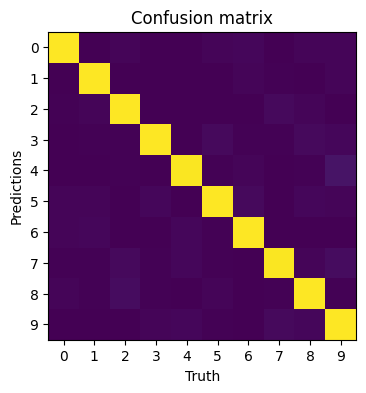

In [9]:
evaluateModel(net, test_loader)

In [10]:
W = torch.tensor(np.array([
    [0.01, 0.02, -0.2, 0.04, 0.33],
    [0.17, -0.42, -0.33, 0.02, -0.05], 
    [0.02, 0.83, -0.03, 0.03, 0.06],
    [-0.9, 0.07, 0.11, 0.87, -0.36], 
    [-0.73, 0.41, 0.42, 0.39, 0.47]]))
bit_length = 4
n1, n2 = getBounderyExponents(W, bit_length)
print(n1, n2)
T = torch.Tensor(np.zeros_like(W))
T = getQuantizationMask(W, 0.5, T)
print(T)
_, W = quantizeWeights(W, T, n1, n2)

W = torch.Tensor(np.array([
    [0.11, 0.04, -0.7, 0.19, -0.25],
    [0.15, -0.5, -0.25, -0.09, -0.02],
    [-0.02, 1, -0.06, 0.21, 0.15],
    [-1, 0.27, -0.09, 1, -0.25],
    [-0.5, 0.5, 0.5, 0.5, 0.5]
]))

T = getQuantizationMask(W, 0.75, T)
_, W = quantizeWeights(W, T, n1, n2)
print(T)
print(W)

0.0 -3.0
tensor([[0., 0., 0., 0., 1.],
        [0., 1., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 1., 1.],
        [1., 1., 1., 1., 1.]])
tensor([[0., 0., 1., 1., 1.],
        [1., 1., 1., 0., 0.],
        [0., 1., 0., 1., 1.],
        [1., 1., 0., 1., 1.],
        [1., 1., 1., 1., 1.]])
tensor([[ 0.1100,  0.0400, -0.5000,  0.2500, -0.2500],
        [ 0.1250, -0.5000, -0.2500, -0.0900, -0.0200],
        [-0.0200,  1.0000, -0.0600,  0.2500,  0.1250],
        [-1.0000,  0.2500, -0.0900,  1.0000, -0.2500],
        [-0.5000,  0.5000,  0.5000,  0.5000,  0.5000]])


In [11]:
number_of_bits = 32
mb_conv = 1.25e-7
number_of_quantized_bits = 5
number_of_weights = 0
model_size = 0

for param in net.parameters():
    nr_weight_layer = 1
    for n in param.size():
        nr_weight_layer *= n
    number_of_weights += nr_weight_layer

model_size = number_of_weights*number_of_bits

print("Numer of weights: "+str(number_of_weights))
print("Size needed to store the model with float32 precision: {:.3f} MB".format(model_size*mb_conv))

model_size = number_of_weights*number_of_quantized_bits
print("Size needed to store the model with {} bits quantization: {:.3f} MB".format(number_of_quantized_bits, model_size*mb_conv))       

Numer of weights: 3603520
Size needed to store the model with float32 precision: 14.414 MB
Size needed to store the model with 5 bits quantization: 2.252 MB


In [12]:
#TO DO
#time reduction with quantization

In [13]:
# net = VGG7()
# net.to(device)

# optimizer = optim.SGD(net.parameters(), lr=1, weight_decay=0)

# b = torch.clone(net.fc3.weight)
# Tfc3 = torch.zeros_like(net.fc3.weight)
# print(net.fc3.weight[:10, 0])
# quantize_fc_layer(net.fc3.weight, Tfc3, 0.5, 5)
# print(Tfc3[:10, 0])
# print(net.fc3.weight[:10, 0])

# net.train()

# data, target = train_data[2]
# target = torch.Tensor([target]).long()
# optimizer.zero_grad()
# output = net(data)
# loss = F.nll_loss(output, target)
# loss.backward()
# net.fc3.weight.grad = net.fc3.weight.grad*(torch.ones_like(Tfc3) - Tfc3)
# optimizer.step()

# print(Tfc3[:10, 0])
# print(net.fc3.weight[:10, 0])